In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

## Hyperparameters and Constants

Here, we define wether to train the model or not and for how many epochs to train for.

If `TRAIN = False`, then the last trained model will be used for inference in the notebook if run end to end.

In [2]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 25

## Download and Prepare the Dataset

We will use the <a href="https://public.roboflow.com/object-detection/pascal-voc-2012" target="_blank">Pascal VOC 2012 Dataset</a> dataset for training the custom YOLOv5 object detector.

Let's download the dataset.

In [3]:
if not os.path.exists('train'):
    !curl -L "https://public.roboflow.com/ds/DaeAw3Sxrd?key=tyDohXkvHq" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/labels/2008_001312_jpg.rf.e1a588f85f3fe5fc2583d05274517591.txt  
 extracting: train/labels/2011_002853_jpg.rf.e1adc0f08261ff95c62f248346a0ce6c.txt  
 extracting: train/labels/2010_000392_jpg.rf.e1be4b0f59951d6d1c2a415b0a6cb494.txt  
 extracting: train/labels/2008_006696_jpg.rf.e1af8b35405b0e49baffda1f3f9064b7.txt  
 extracting: train/labels/2009_002193_jpg.rf.e1c5b025e045ebb1f244e280d363861a.txt  
 extracting: train/labels/2009_001707_jpg.rf.e1cb218fc7e2cdc591c3dc32392aa75e.txt  
 extracting: train/labels/2011_000203_jpg.rf.e1cefbd4d0fd92b2162256acdd7b00c4.txt  
 extracting: train/labels/2007_009649_jpg.rf.e1d6620b50f73a38fbc41225c8acea1f.txt  
 extracting: train/labels/2008_004599_jpg.rf.e1d98a39440ef6e401062e107c329c72.txt  
 extracting: train/labels/2010_003169_jpg.rf.e1db1e98b1d8d5f23180fa09288680a0.txt  
 extracting: train/labels/2010_006263_jpg.rf.e1dbf738331c9405f0fc046d885ce043.txt  
 extracting: train/labels

The dataset is structured in the following manner:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
└── train
    ├── images
    └── labels

```

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset.

The dataset contains 20 classes: **''aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'**.

The following block shows the contents of the `data.yaml` file.

```yaml
train: ../train/images
val: ../valid/images

nc: 20
names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
```

## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [4]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [5]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Clone YOLOV5 Repository

In [6]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 12727, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 12727 (delta 51), reused 65 (delta 34), pack-reused 12633
Receiving objects: 100% (12727/12727), 12.93 MiB | 28.16 MiB/s, done.
Resolving deltas: 100% (8760/8760), done.


In [7]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [8]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.2 MB/s 


## Check Out the Validation Predictions and Inference

In this section, we will check out the predictions of the validation images saved during training. Along with that, we will also check out inference of videos.

### Visualization and Inference Utilities

We will visualize the validation prediction images that are saved during training. The following is the function for that.

In [9]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on videos.

In [10]:
# Helper function for inference on videos.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on videos.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

## Training using YOLOV5

The next step is to train the neural network model.

We will freeze layers and train the Medium model.

The Medium model (yolov5m) contains 25 blocks layers in total more than 20 million parameters. We don't need to train all the layers. Let's freeze a few layers and train again. This will result in faster iteration per epoch. Here, we freeze the first 15 blocks.

### Training

In [11]:
# First, we load Teansorboard
monitor_tensorboard()

<IPython.core.display.Javascript object>

In [12]:
# Training with fine tuning
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5m.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} \
    --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

Current number of result directories: 0
results_1
train: weights=yolov5m.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-162-g55fbac9 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls

Now, we visualize validation prediction images.

confusion_matrix.png				   results.png
events.out.tfevents.1664097170.3b0aed6e9528.230.0  train_batch0.jpg
F1_curve.png					   train_batch1.jpg
hyp.yaml					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
opt.yaml					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights
['runs/train/results_1/val_batch1_pred.jpg', 'runs/train/results_1/val_batch0_pred.jpg', 'runs/train/results_1/val_batch2_pred.jpg']


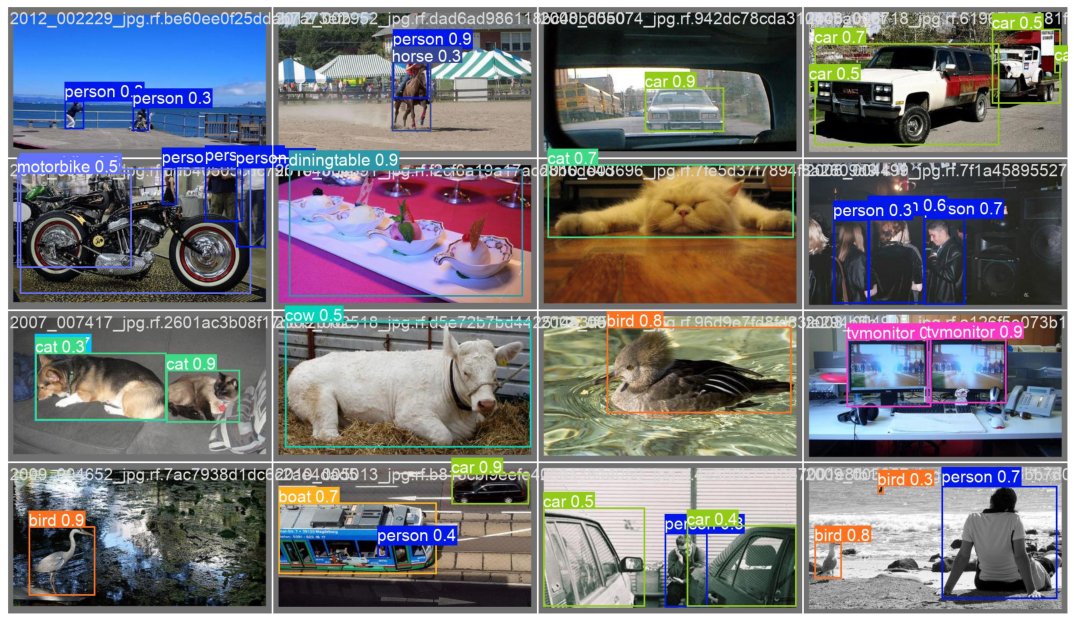

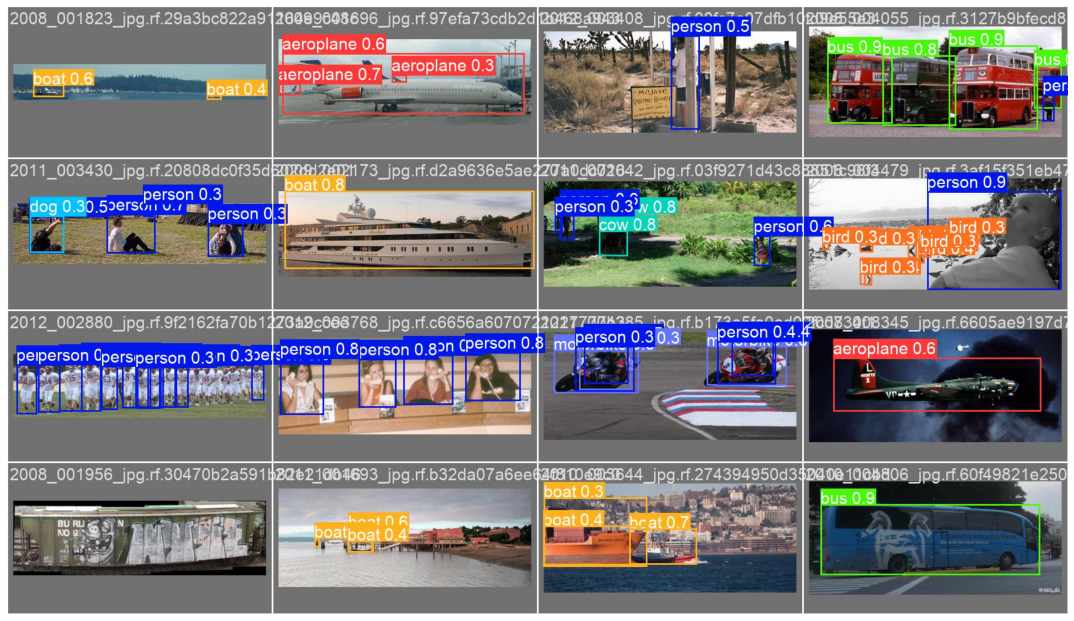

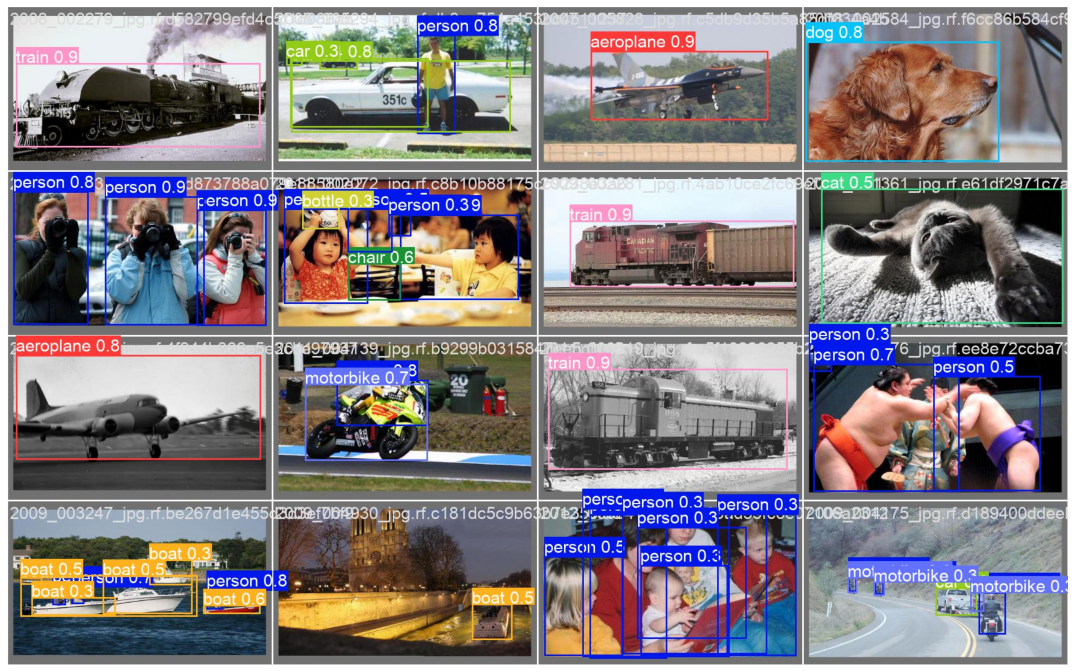

In [13]:
show_valid_results(RES_DIR)

### Inference

In this section, we will carry out inference on unseen videos. 

We locate the videos for inference are in the `yolov5/inference_videos` directory.

It is possible to download some videos and images from Internet by executing the following cell.

In [14]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')
    
   
download_file('https://learnopencv.s3.us-west-2.amazonaws.com/yolov5_inference_data.zip',
              'inference_data.zip')
if not os.path.exists('inference_images'):
    !unzip -q "inference_data.zip"
else:
    print('Dataset already present')

In [15]:
# Inference on images
inference(RES_DIR, 'inference_videos')

Current number of inference detection directories: 0
inference_1
detect: weights=['runs/train/results_1/weights/best.pt'], source=inference_videos, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-162-g55fbac9 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 212 layers, 20929713 parameters, 0 gradients, 48.1 GFLOPs
video 1/4 (1/513) /content/yolov5/inference_videos/video_1.mp4: 384x640 (no detections), 21.8ms
video 1/4 (2/513) /content/yolov5/inference_videos/video_1.mp4: 384x640 1 bus, 4 cars, 1 person, 21.7ms
video 1/4 (3/513) /content/yolov5/inference_videos/video_1.mp4: 384x6

'inference_1'